In [5]:
#5.4.1
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy
    
apple = 100
apple_num = 2
tax = 1.1

#layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

#forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print (price)

#backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
print (dapple, dapple_num, dtax)

220.00000000000003
2.2 110.00000000000001 200


In [7]:
#5.4.2
class AddLayer:
    def __init__(self):
        pass
    def forward(self, x, y):
        out = x + y
        return out
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

#layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

#forward
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

print (price)

#backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
print (dapple, dapple_num, dorange, dorange_num, dtax)

715.0000000000001
2.2 110.00000000000001 3.3000000000000003 165.0 650


In [10]:
#5.5.1
class Relu:
    def __init__(self):
        self.mask = None
    def forward(self, x):
        self.mask = (x <= 0) #TRUE or FALSEを格納する
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

In [9]:
import numpy as np
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print (x)
mask = (x <= 0)
print (mask)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]


In [11]:
#5.5.2
class Sigmoid:
    def __init__(self):
        self.out = None
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [23]:
#5.6.2
import numpy as np
X_dot_W = np.array([[0, 0, 0], [10, 10, 10]])
B = np.array([1, 2, 3])
print (X_dot_W + B)
dY = np.array([[1, 2, 3], [4, 5, 6]])
dB = np.sum(dY, axis=0)
print (str(dY)+" : dY")
print (str(dB)+" : dB")

[[ 1  2  3]
 [11 12 13]]
[[1 2 3]
 [4 5 6]] : dY
[5 7 9] : dB


In [24]:
#5.6.2 Affine
import numpy as np
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

In [25]:
#5.6.3 SoftmaxWithLoss
import numpy as np
from functions import softmax, cross_entropy_error
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

In [5]:
#5.7.2
import sys, os
sys.path.append(os.pardir)
import numpy as np
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim !=1 : t = np.argmax(t, axis=1)    
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    def gradient(self, x, t):
        self.loss(x, t)
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layres.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db 
        return grads

In [9]:
#5.7.3
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)#誤記！
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
x_batch = x_train[:3]
t_batch = t_train[:3]
grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W2:1.51834056578e-11
b2:1.20348164767e-10
W1:4.69625573164e-13
b1:1.3117961944e-12


0.0993 0.1032
0.78785 0.7919
0.874533333333 0.8788
0.8985 0.9012
0.908516666667 0.9116
0.914633333333 0.9166
0.920066666667 0.921
0.92395 0.9268
0.927816666667 0.9294
0.93115 0.9325
0.933516666667 0.9341
0.936666666667 0.9377
0.938933333333 0.94
0.941333333333 0.9411
0.943033333333 0.9436
0.94555 0.9444
0.946716666667 0.9469


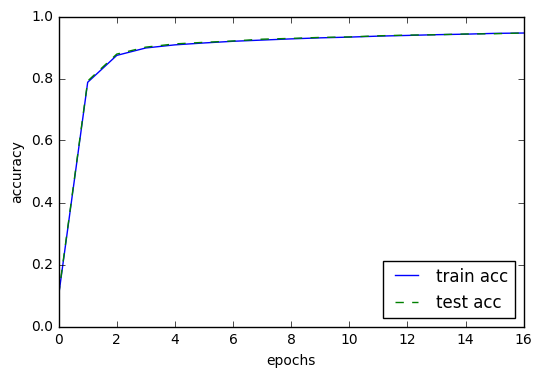

In [12]:
#5.7.4
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    grad = network.gradient(x_batch, t_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)
        
# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()